<a href="https://colab.research.google.com/github/Madhusti-D/Hardware_Security/blob/main/MLP_PSA_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing necessary libraries**

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

**Checking GPU Availability**

In [2]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Mount Google Colab**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Pre-Processing**

Creating a dataset like MNIST or CIFAR 10 where these datasets contain data and its corresponding labels mapped to it.


1. Organizing Data and Labels
2. Data Preprocessing
3. Transforming Data and Labels into Tensors
4. Data Splitting
5. Creating Data Loaders for batching and shuffling






In [4]:
# Directory where the 10,000 files are located
directory_path = '/content/drive/MyDrive/PSA_SAR ADC/Dataset/unzipped/No_Dither/'

In [5]:
# Initialize an empty list to hold all data
all_data = []

In [6]:
# Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        # Drop any unnecessary columns like the unnamed index
        df_clean = df.drop(columns=['Unnamed: 0','time'])
        all_data.append(df_clean)

In [7]:
# Option 1: Check the number of DataFrames in the list
print("Number of DataFrames in all_data:", len(all_data))

Number of DataFrames in all_data: 10001


In [8]:
# Option 3: Concatenate all DataFrames and check the shape
combined_data = pd.concat(all_data, ignore_index=True)
print("Shape of combined_data:", combined_data.shape)

Shape of combined_data: (26002600, 1)


In [9]:
# Loading Labels and Encoding
labels_df = pd.read_csv('/content/drive/MyDrive/PSA_SAR ADC/Dataset/CNN_100u_no_dither_labels.csv')
y = labels_df['Dout-1-15us Y'].values - 1 # Assuming labels range from 1-31, change to 0-30


In [10]:
# Convert combined_data DataFrame to a NumPy array with float type
X = combined_data.astype(float).values

fit_transform(X): Fits the scaler to X and transforms the data. This will ensure that all features are standardized (mean = 0, standard deviation = 1).

In [11]:
# Convert to float32 for compatibility and memory efficiency
X = X.astype(np.float32)
print("Data type of features after conversion:", X.dtype)  # Should print: float32

Data type of features after conversion: float32


In [12]:
# Expand the labels to match each row in X
y_expanded = np.repeat(y, 2600)

# Verify the length of y_expanded
print("Length of expanded labels:", len(y_expanded))  # Should be 26,002,600

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_expanded, test_size=0.2, random_state=42, stratify=y_expanded)

# Verify the shapes of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Length of expanded labels: 26002600
X_train shape: (20802080, 1)
X_test shape: (5200520, 1)
y_train shape: (20802080,)
y_test shape: (5200520,)


**stratify=y_expanded:** Ensures that the class distribution is proportional in both the training and test sets.

In [13]:
# Training loop for 5-bit ADC
N = 5  # Number of bits in the ADC
epochs = 5
batch_size = 32

**Building the model**

In [14]:
# Define the model with regularization and dropout
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(2, activation='softmax'))
    return model

In [15]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
# Learning rate schedule
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.9)

In [17]:
# Optimizer with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [28]:
# Feature extraction: Min-Max scaling for all features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Assuming 'X' contains min/max feature vectors extracted from supply current waveforms

**Training the Models**

**Bit Extraction Explained**


1.   y_train >> bit: This right-shifts the value in y_train by bit positions.
2.   & 1: This operation extracts the least significant bit (LSB) after the shift.


This means:
bit = 0 corresponds to extracting the least significant bit (LSB).

As bit increases, you are extracting higher-order bits, with the most significant bit (MSB) being trained last.

**Order of Training**

The training happens from the least significant bit (LSB) to the most significant bit (MSB):



  Iteration 0 (bit = 0): The LSB is trained first.

  Iteration 1 (bit = 1): The next bit is trained.

  ...

  Iteration N-1 (bit = N-1): The MSB is trained last.



**Example**
Suppose here we have a 5-bit number y = 13 (in binary: 01101)

*   bit = 0: (y >> 0) & 1 extracts the LSB (1).
*   bit = 1: (y >> 1) & 1 extracts the next bit (0).
*   bit = 2: (y >> 2) & 1 extracts the next bit (1).
*   bit = 3: (y >> 3) & 1 extracts the next bit (1).
*   bit = 4: (y >> 4) & 1 extracts the MSB (0).

In [29]:
# Train a model for each bit
models = []
history_list = []

for bit in range(N):
    # Extract labels for the specific bit
    y_bit = (y_train >> bit) & 1  # Extract the bit

    # Calculate class weights
    classes = np.unique(y_bit)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_bit)
    class_weight_dict = {i: class_weights[i] for i in range(len(classes))}

    # Create and compile the model
    model = create_model()

    # Learning rate schedule for each model
    lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.9)

    # Create a new optimizer instance for each model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_bit, epochs=10, batch_size=512, validation_split=0.2,
                        verbose=1, callbacks=[early_stopping], class_weight=class_weight_dict)

    # Store the trained model and history
    models.append(model)
    history_list.append(history)

Epoch 1/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - accuracy: 0.4998 - loss: 0.6936 - val_accuracy: 0.5046 - val_loss: 0.6932
Epoch 2/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.4954 - val_loss: 0.6932
Epoch 3/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accuracy: 0.4954 - val_loss: 0.6932
Epoch 4/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accuracy: 0.4954 - val_loss: 0.6932
Epoch 5/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accuracy: 0.4954 - val_loss: 0.6932
Epoch 1/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - accuracy: 0.5002 - loss: 0.6936 - val_accuracy: 0.4869 - val_loss: 0.6932
Epoch 2/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.4869 - val_loss: 0.6932
Epoch 3/10
32504/32504 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 

**Visualization of output**

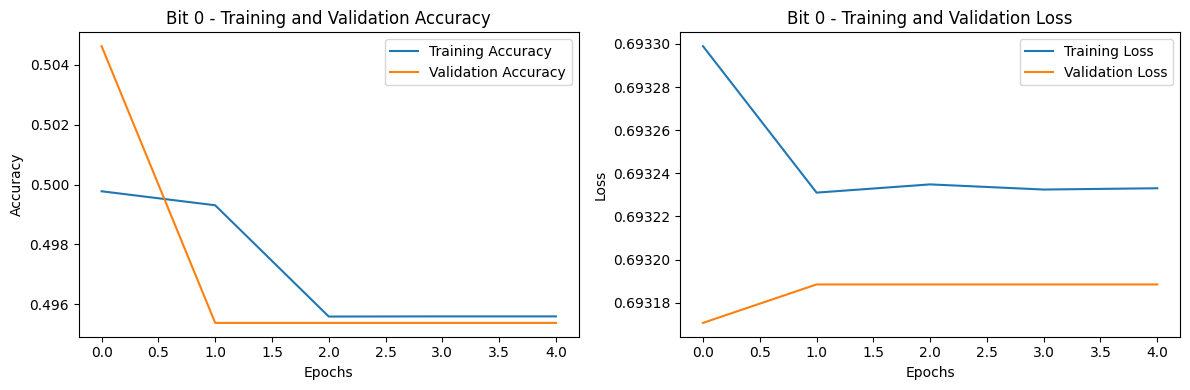

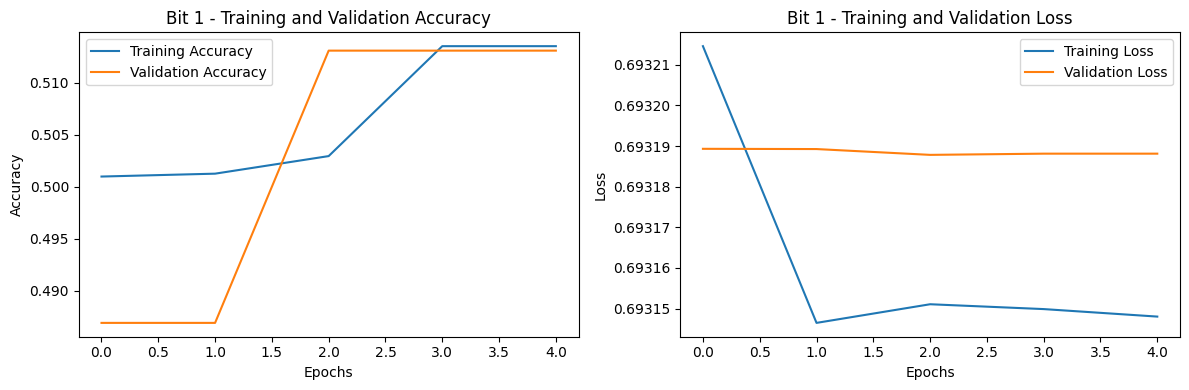

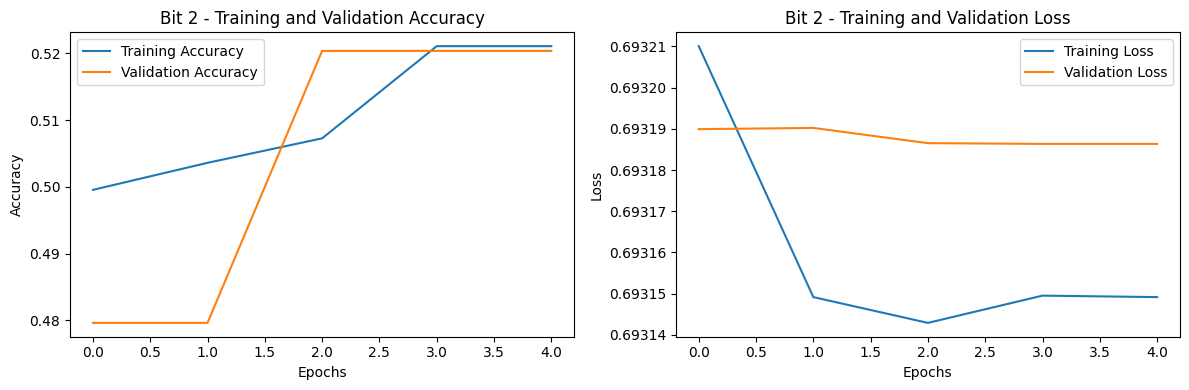

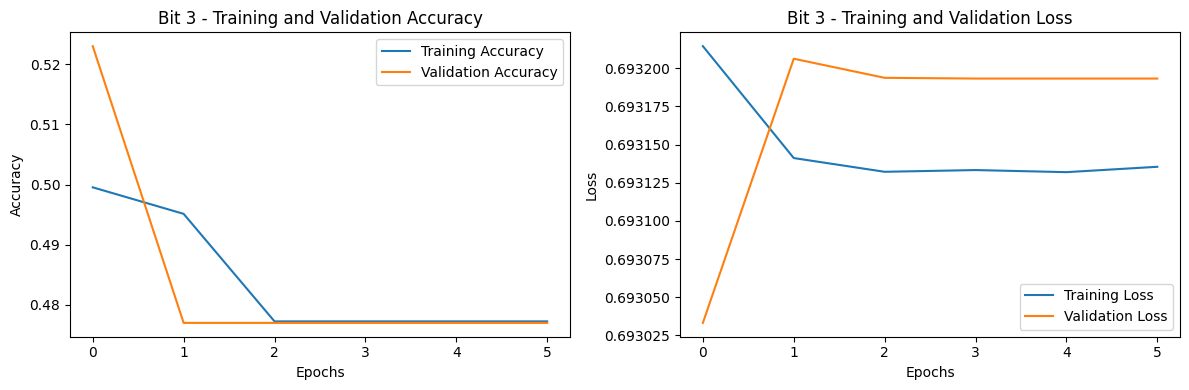

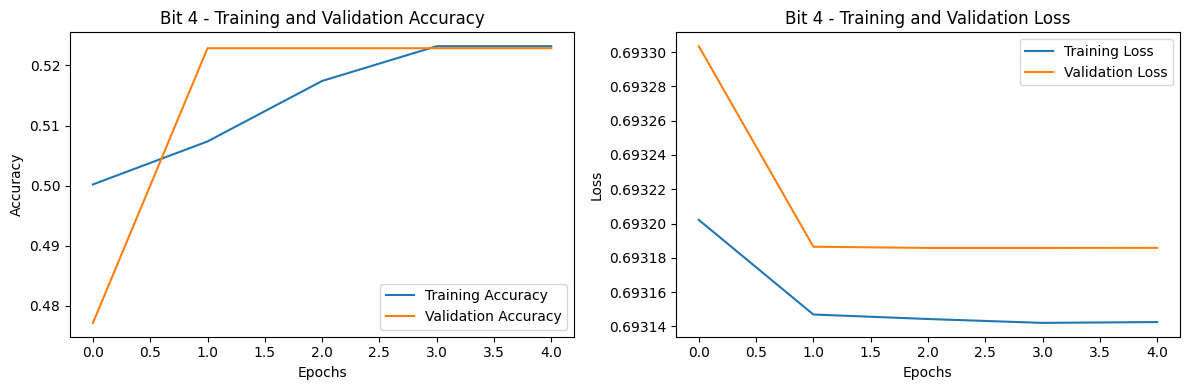

In [30]:
# Plot training and validation accuracy/loss for each model
def plot_training_history(history_list, N):
    for bit in range(N):
        history = history_list[bit]

        # Plot training and validation accuracy
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Bit {bit} - Training and Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Bit {bit} - Training and Validation Loss')
        plt.legend()

        # Show the plots
        plt.tight_layout()
        plt.show()

# Plot the training history
plot_training_history(history_list, N)

**Evaluating the Model**

In [32]:
# Prediction for the test set
target_features = scaler.transform(X_test)
predicted_bits = np.zeros((target_features.shape[0], N), dtype=int)

# Predict each bit
for bit in range(N):
    bit_predictions = models[bit].predict(target_features)
    predicted_bits[:, bit] = np.argmax(bit_predictions, axis=1)  # Get the predicted class (0 or 1)

    #predicted_bits[:, bit] = (bit_predictions.flatten() > 0.5).astype(int)  # Flatten the predictions to match the shape

# Combine bits to form the final ADC output
adc_output_predictions = np.sum(predicted_bits * (2 ** np.arange(N)), axis=1)
# Evaluate and compare predictions with true labels
true_adc_outputs = y_test  # Assuming y_test contains the true ADC output codes
accuracy = np.mean(adc_output_predictions == true_adc_outputs)
print(f"Overall ADC Output Prediction Accuracy: {accuracy * 100:.2f}%")



162517/162517 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step
162517/162517 ━━━━━━━━━━━━━━━━━━━━ 164s 1ms/step
162517/162517 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step
162517/162517 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step
162517/162517 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step
Overall ADC Output Prediction Accuracy: 2.68%
Bit 0 Prediction Accuracy: 50.44%
Bit 1 Prediction Accuracy: 51.34%
Bit 2 Prediction Accuracy: 52.09%
Bit 3 Prediction Accuracy: 52.28%
Bit 4 Prediction Accuracy: 52.31%


In [34]:
# Bitwise Accuracy Evaluation
bitwise_accuracies = []
for bit in range(N):
    bit_accuracy = np.mean(predicted_bits[:, bit] == ((true_adc_outputs >> bit) & 1))
    bitwise_accuracies.append(bit_accuracy)
    print(f"Bit {bit} Prediction Accuracy: {bit_accuracy * 100:.2f}%")

Bit 0 Prediction Accuracy: 50.44%
Bit 1 Prediction Accuracy: 51.34%
Bit 2 Prediction Accuracy: 52.09%
Bit 3 Prediction Accuracy: 52.28%
Bit 4 Prediction Accuracy: 52.31%


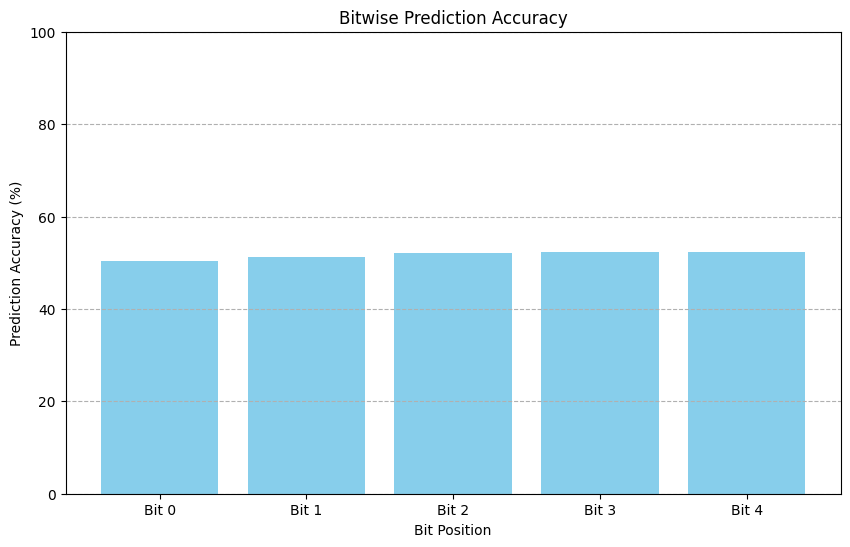

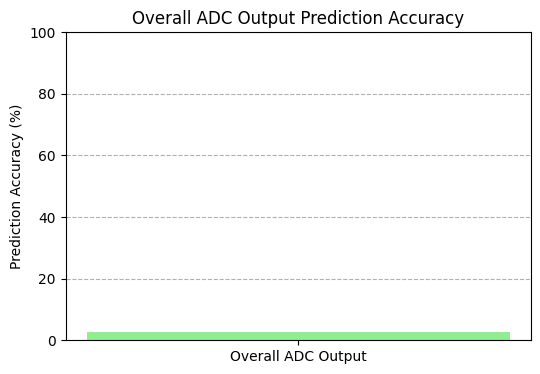

In [36]:
# Plot bitwise accuracy for each bit
plt.figure(figsize=(10, 6))
plt.bar(range(N), [acc * 100 for acc in bitwise_accuracies], color='skyblue')
plt.xlabel('Bit Position')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Bitwise Prediction Accuracy')
plt.xticks(range(N), [f'Bit {i}' for i in range(N)])
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--')
plt.show()

# Plot overall ADC output prediction accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Overall ADC Output'], [accuracy * 100], color='lightgreen')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Overall ADC Output Prediction Accuracy')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--')
plt.show()